In [1]:
import pyprind 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

- *.dump file contains the dump obtained from the lammps output (Has all the LAMMPS calculated quantities for each atom)
- LAMMPS does not arrange the atoms in order of their indices like DL-POLY does

In [2]:
import glob, os

def load_dump_files(file_path):
    '''Inputs:
        file_path=path to the directories where the dump files are located
        label = ID for the atom in the LAMMPS dump file
       Outputs:
        dump_contents = contents of variable values form all the snapshots in chronological order
        num_snaps = total number of snapshots present in the study       
        box = list of the box size at each snapshot
    '''
    dump_contents, box = [],[]
    files = sorted(glob.glob(file_path, recursive=True))
    num_snaps = 0
    for filename in files:
        num_snaps += 1
        with open(filename, 'r',encoding='utf-8') as infile:
            print(filename)
            txt = infile.readlines()
            for line in txt[9:]:
                dump_contents.append(np.array(line.split()).astype(float)[:5] )
            box.append(float(txt[5].split()[1]) - float(txt[5].split()[0]))
    return dump_contents, num_snaps, box


In [3]:
# label="3" for O, "2" for Nb, "1" for Li
dump_contents, num_snaps, box = load_dump_files(file_path = './*/**.dump')

./0000ps/0ps.dump
./0100ps/100ps.dump
./0200ps/200ps.dump
./0300ps/300ps.dump
./0400ps/400ps.dump
./0500ps/500ps.dump
./0600ps/600ps.dump
./0700ps/700ps.dump
./0800ps/800ps.dump
./0900ps/900ps.dump
./1000ps/1000ps.dump
./1100ps/1100ps.dump
./1200ps/1200ps.dump
./1300ps/1300ps.dump
./1400ps/1400ps.dump
./1500ps/1500ps.dump
./1600ps/1600ps.dump
./1700ps/1700ps.dump
./1800ps/1800ps.dump
./1900ps/1900ps.dump
./2000ps/2000ps.dump
./2100ps/2100ps.dump
./2200ps/2200ps.dump
./2300ps/2300ps.dump
./2400ps/2400ps.dump


In [4]:
NAT=(int(len(dump_contents)/num_snaps))
print("No. of atoms: %d \nNo. of snaps: %d"%(NAT, num_snaps))


No. of atoms: 101345 
No. of snaps: 25


In [5]:
df = pd.DataFrame(dump_contents)

df.columns=["Number","Type","x","y","z"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533625 entries, 0 to 2533624
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Number  float64
 1   Type    float64
 2   x       float64
 3   y       float64
 4   z       float64
dtypes: float64(5)
memory usage: 96.7 MB


In [6]:
# Change the data type of the columns appropriately
df = df.astype({"Number": int, "Type": int, "x": float, "y":float, "z":float})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533625 entries, 0 to 2533624
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Number  int64  
 1   Type    int64  
 2   x       float64
 3   y       float64
 4   z       float64
dtypes: float64(3), int64(2)
memory usage: 96.7 MB


In [7]:
df['dist_from_c'] = np.sqrt((df['x']**2+df['y']**2+df['z']**2))


In [8]:
#Pull out atoms closer than 15 A from the center
df = df[["Number","Type","dist_from_c"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533625 entries, 0 to 2533624
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Number       int64  
 1   Type         int64  
 2   dist_from_c  float64
dtypes: float64(1), int64(2)
memory usage: 58.0 MB


In [9]:
df_Si = df[(df['Type'] == 4)]
df_Si.tail()

,Number,Type,dist_from_c
2532439,101127,4,76.871654
2532704,100955,4,84.377226
2532943,101125,4,73.509114
2533018,101062,4,91.087551
2533158,100978,4,70.813166


In [10]:
NAT_Si = 200
split_dataframes = [df_Si[i:i+NAT_Si] for i in range(0, len(df_Si), NAT_Si)]
sorted_chunks = [chunk.sort_values(by='Number') for chunk in split_dataframes]


sorted_chunks[0].head()


,Number,Type,dist_from_c
56600,100946,4,44.137779
91923,100947,4,64.875805
94273,100948,4,60.411011
25609,100949,4,53.954186
8207,100950,4,47.720282


In [11]:
sorted_chunks[0].describe()

,Number,Type,dist_from_c
count,200.000000,200.0,200.000000
mean,101045.500000,4.0,52.607175
std,57.879185,0.0,13.734434
min,100946.000000,4.0,18.879657
25%,100995.750000,4.0,42.960532
50%,101045.500000,4.0,53.854586
75%,101095.250000,4.0,62.331034
max,101145.000000,4.0,87.922758


Since the 25% dist is 42.5, lets focus on Si atoms below 45 A distance from the center.
We need to identify what atoms they are at 0ps and then track the evolution of their distance from the center. 

In [75]:
cut_off = 25.0
# Filter atoms that are below cut_off
tmp = sorted_chunks[0][sorted_chunks[0]['dist_from_c'] < cut_off]

# Find the atom number for those atoms below cut_off
num_list_Si = tmp['Number'].tolist()
print(num_list_Si)

In [77]:
# Create an array to store the position of these Si atoms at each snapshot
# An extra column to be added to accomodate the Number column in the first column
stored_vals = np.zeros([len(num_list_Si),num_snaps+1])
stored_vals[:,0] = (num_list_Si)

stored_vals

__Populate the stored_vals array with the coordinates of the filtered Si atoms__

In [82]:
for ind in range(num_snaps):
    df_snap = sorted_chunks[ind]
    filtered_df = df_snap[df_snap['Number'].isin(num_list_Si)].sort_values(by='Number')
    stored_vals[:,ind+1] = filtered_df['dist_from_c']

stored_vals

__Create a calculation to estimate the equivalent crystal sphere for each of the snapshot used in the ML algorithm__

In [85]:
data = np.loadtxt("c_size_evol.txt")
# This gives us the crystal factor X at different snapshots of the SCG 
data[:,0] /= data.sum(axis=1)

# Let us find an equivalent volume that is crystallized
# Since the box is ~ 112 A
box = 113
eq_sphere = [np.cbrt(x*box**3/(4*np.pi)) for x in data[:,0]]
print(eq_sphere)

[13.062071733586128, 13.29744224453087, 13.748017575887626, 13.892917536609216, 14.31963548268845, 14.628873819232252, 15.664833202803257, 16.27161784105408, 16.23828890358686, 16.926732842122014, 17.56127582519009, 17.40072071567257, 18.407123233207752, 19.143965094086216, 19.945768095832573, 20.30146263765709, 21.146422230325978, 21.591348587272588, 22.306791363445875, 23.304414742313913, 24.198556869098677, 25.133080845487175, 25.799377627664263, 26.308103033130998]


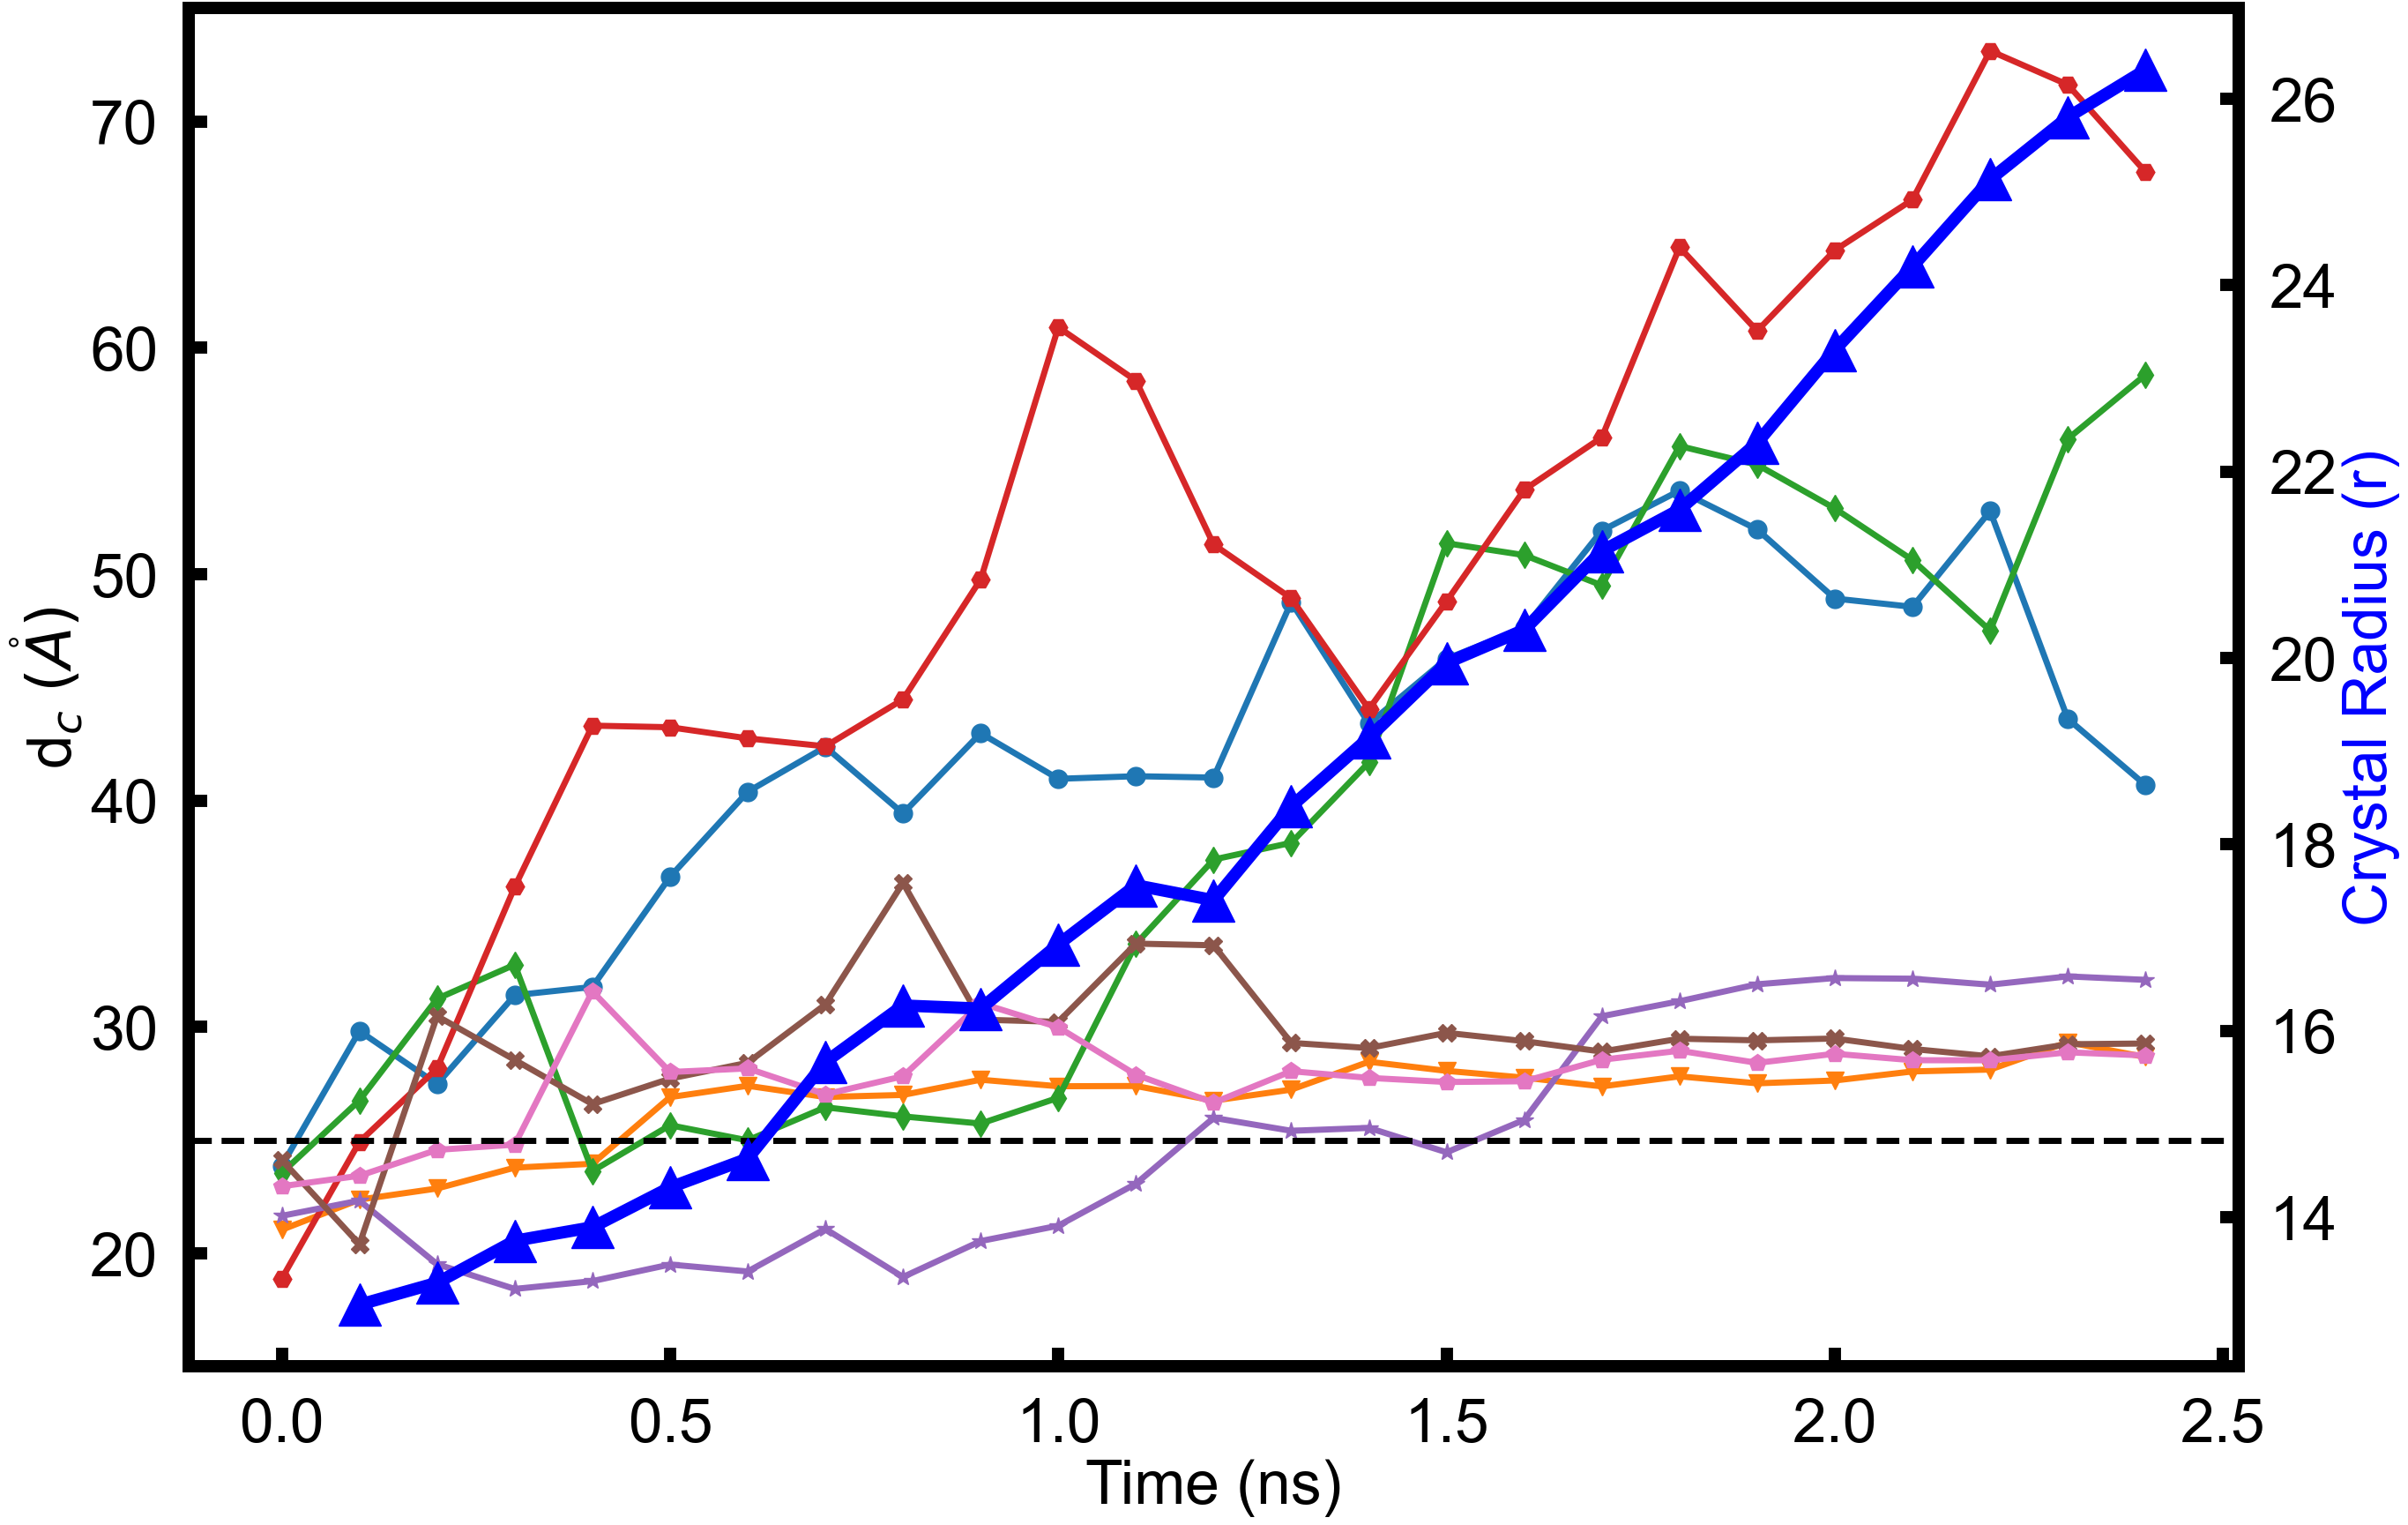

In [86]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 50
plt.rcParams['axes.labelsize'] = 50
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 75
plt.rcParams['axes.titleweight']='normal'
plt.rcParams['xtick.labelsize'] =50
plt.rcParams['ytick.labelsize'] =50
plt.rcParams['lines.linewidth']=5.0
plt.rcParams['figure.figsize'] = 30,20
plt.rcParams['lines.markersize']=15.0
plt.rcParams['axes.linewidth'] =10

plt.rcParams['xtick.major.size']=15
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['xtick.major.width']=10.0

plt.rcParams['ytick.major.size']=15
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['ytick.major.width']=10.0

plt.rcParams['xtick.major.pad']='25'
plt.rcParams['ytick.major.pad']='25'
markers = ['o','v','d','H','*','X','p']



fig, ax1 = plt.subplots()

# Creating another y-axis and plotting the second set of data on the right y-axis
ax2 = ax1.twinx()


t = np.arange(0.0,2.5,0.1)
for ind in range(len(num_list_Si)):
    ax1.plot(t,stored_vals[ind,1:],marker=markers[ind])#,label=str(stored_vals[ind,0]))
ax2.plot(np.arange(0.1,2.5,0.1), eq_sphere, color = 'blue', marker='^', markersize=35.0, lw=10.0)    

ax1.axhline(y=25.0, linestyle='--',color='k')
ax1.set_ylabel("d$_c$ $(\mathring{A})$")
ax2.set_ylabel("Crystal Radius (r)", color='blue')
ax1.set_xlabel("Time (ns)")
ax1.set_ylim(15,75)
plt.savefig("Si_lt_25.pdf",bbox_inches='tight')
plt.show()

In [87]:
# Let us see what the change in d_c looks like


# Compute  change
change = [int(i) for i in (stored_vals[:, -1] - stored_vals[:, 2])]

# Add a new column with the change to your array
# Assuming you want to add this new column as the last column
new_array = np.column_stack((stored_vals, change))

# Print the new array
print(new_array)


[[1.00970000e+05 2.38645548e+01 2.98161178e+01 2.74711780e+01
  3.13985777e+01 3.17632917e+01 3.66272070e+01 4.03841724e+01
  4.23654121e+01 3.94275600e+01 4.29722816e+01 4.09570134e+01
  4.10717439e+01 4.10126941e+01 4.87652159e+01 4.33924996e+01
  4.62609939e+01 4.76157108e+01 5.19232574e+01 5.36865121e+01
  5.19734275e+01 4.89196792e+01 4.85528832e+01 5.27840460e+01
  4.36077541e+01 4.06808710e+01 1.00000000e+01]
 [1.00974000e+05 2.10372449e+01 2.23688933e+01 2.28603775e+01
  2.37809488e+01 2.39530931e+01 2.68959967e+01 2.73970250e+01
  2.69016683e+01 2.69927174e+01 2.76648331e+01 2.73761691e+01
  2.73879469e+01 2.67404095e+01 2.72277209e+01 2.84584140e+01
  2.80565330e+01 2.77573365e+01 2.73709597e+01 2.78135389e+01
  2.75054523e+01 2.76307788e+01 2.80310663e+01 2.81134028e+01
  2.93236400e+01 2.86673473e+01 6.00000000e+00]
 [1.01019000e+05 2.35462433e+01 2.67525224e+01 3.12425509e+01
  3.27470295e+01 2.36297875e+01 2.56547182e+01 2.49868159e+01
  2.64473872e+01 2.60452646e+01 2.57

In [88]:
# What does the change in d_c for each atom look like
print(sorted(new_array[:,-1]))

[5.0, 6.0, 8.0, 9.0, 10.0, 32.0, 42.0]


In [89]:
# Get unique values and their counts
unique_values, value_counts = np.unique(new_array[:, -1], return_counts=True)

# Create a dictionary for the frequency distribution
frequency_distribution = dict(zip(unique_values, value_counts))

# Print the frequency distribution
print(frequency_distribution)


{5.0: 1, 6.0: 1, 8.0: 1, 9.0: 1, 10.0: 1, 32.0: 1, 42.0: 1}


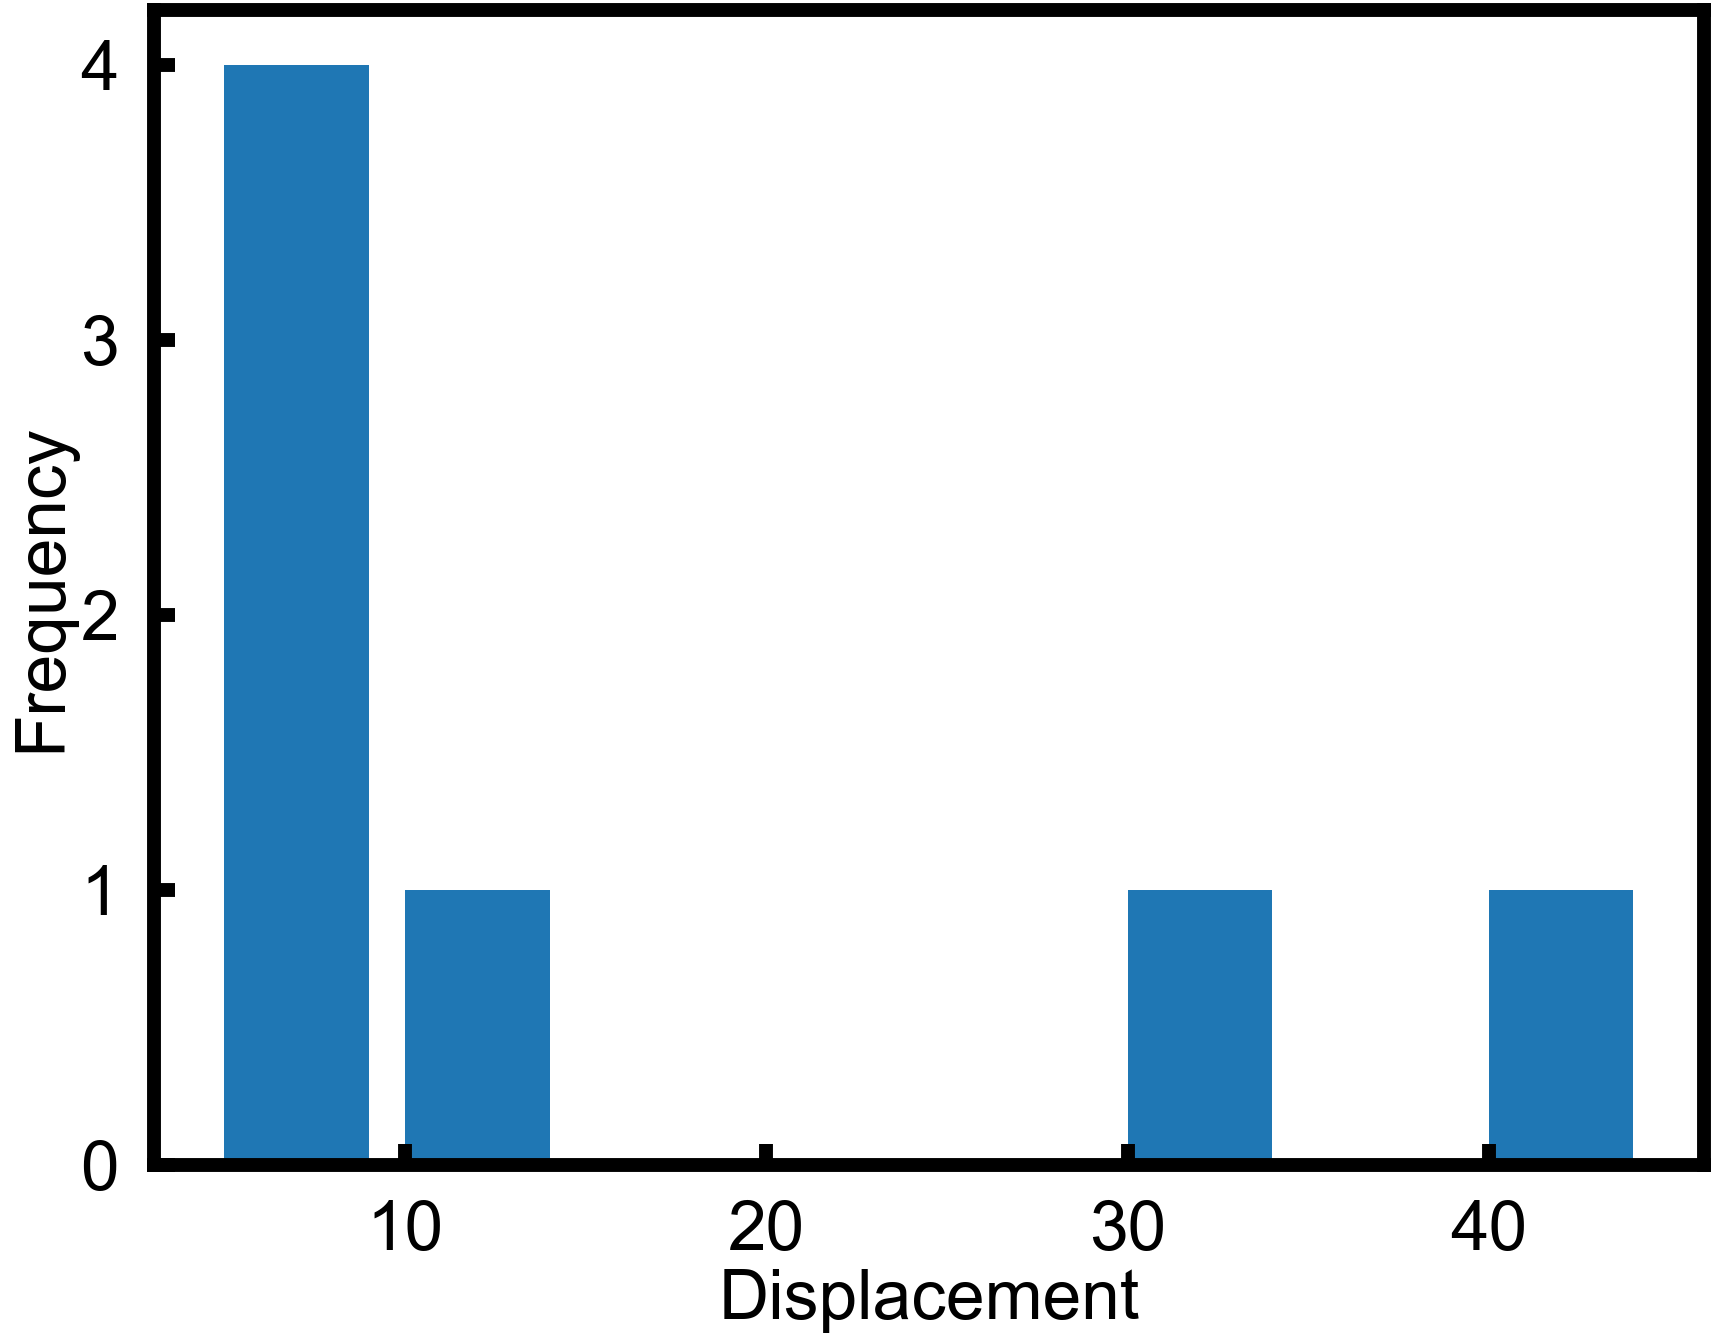

In [90]:
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = 20,15

# Define the bins with an interval of 5
bins = np.arange(min(frequency_distribution.keys()), max(frequency_distribution.keys()) + 6, 5)

# Initialize an array to store frequencies within each bin
binned_frequencies = np.zeros(len(bins) - 1)

# Iterate over the frequency distribution to bin the frequencies
for value, frequency in frequency_distribution.items():
    bin_index = int((value - min(bins)) // 5)
    if bin_index >= 0 and bin_index < len(binned_frequencies):
        binned_frequencies[bin_index] += frequency

# Plotting the bar graph
plt.bar(bins[:-1], binned_frequencies, width=4, align='edge')

# Adding labels and title
plt.xlabel('Displacement')
plt.ylabel('Frequency')
# plt.title('Frequency Distribution of Si-displacement')

# Display the plot
plt.show()


In [92]:
# Initialize sum
inward_movers = 0
outward_movers = 0
# Iterate over keys and sum values for negative keys
for key, value in frequency_distribution.items():
    if key < 0:
        inward_movers += value
    else:
        outward_movers += value
print("Number of Si atoms going inward:", inward_movers)
print("Number of Si atoms going outward:",  outward_movers)

Number of Si atoms going inward: 0
Number of Si atoms going outward: 7


__Let us look at things the other way around__

    - Focus on atoms that are below 29 A at the end of the simulation
    - Track those particles from the start of the simualtion

In [94]:
# How many snapshots do we have?
len(sorted_chunks)

25

In [109]:
cut_off = 29.0
# Filter atoms that are below cut_off
tmp = sorted_chunks[24][sorted_chunks[24]['dist_from_c'] < cut_off]

# Find the atom number for those atoms below cut_off
num_list_Si = tmp['Number'].tolist()
num_list_Si

[100974, 100980, 101032, 101083, 101112]

In [110]:
stored_vals = np.zeros([len(num_list_Si),num_snaps+1])
stored_vals[:,0] = (num_list_Si)

In [111]:
for ind in range(num_snaps):
    df_snap = sorted_chunks[ind]
    filtered_df = df_snap[df_snap['Number'].isin(num_list_Si)].sort_values(by='Number')
    stored_vals[:,ind+1] = filtered_df['dist_from_c']

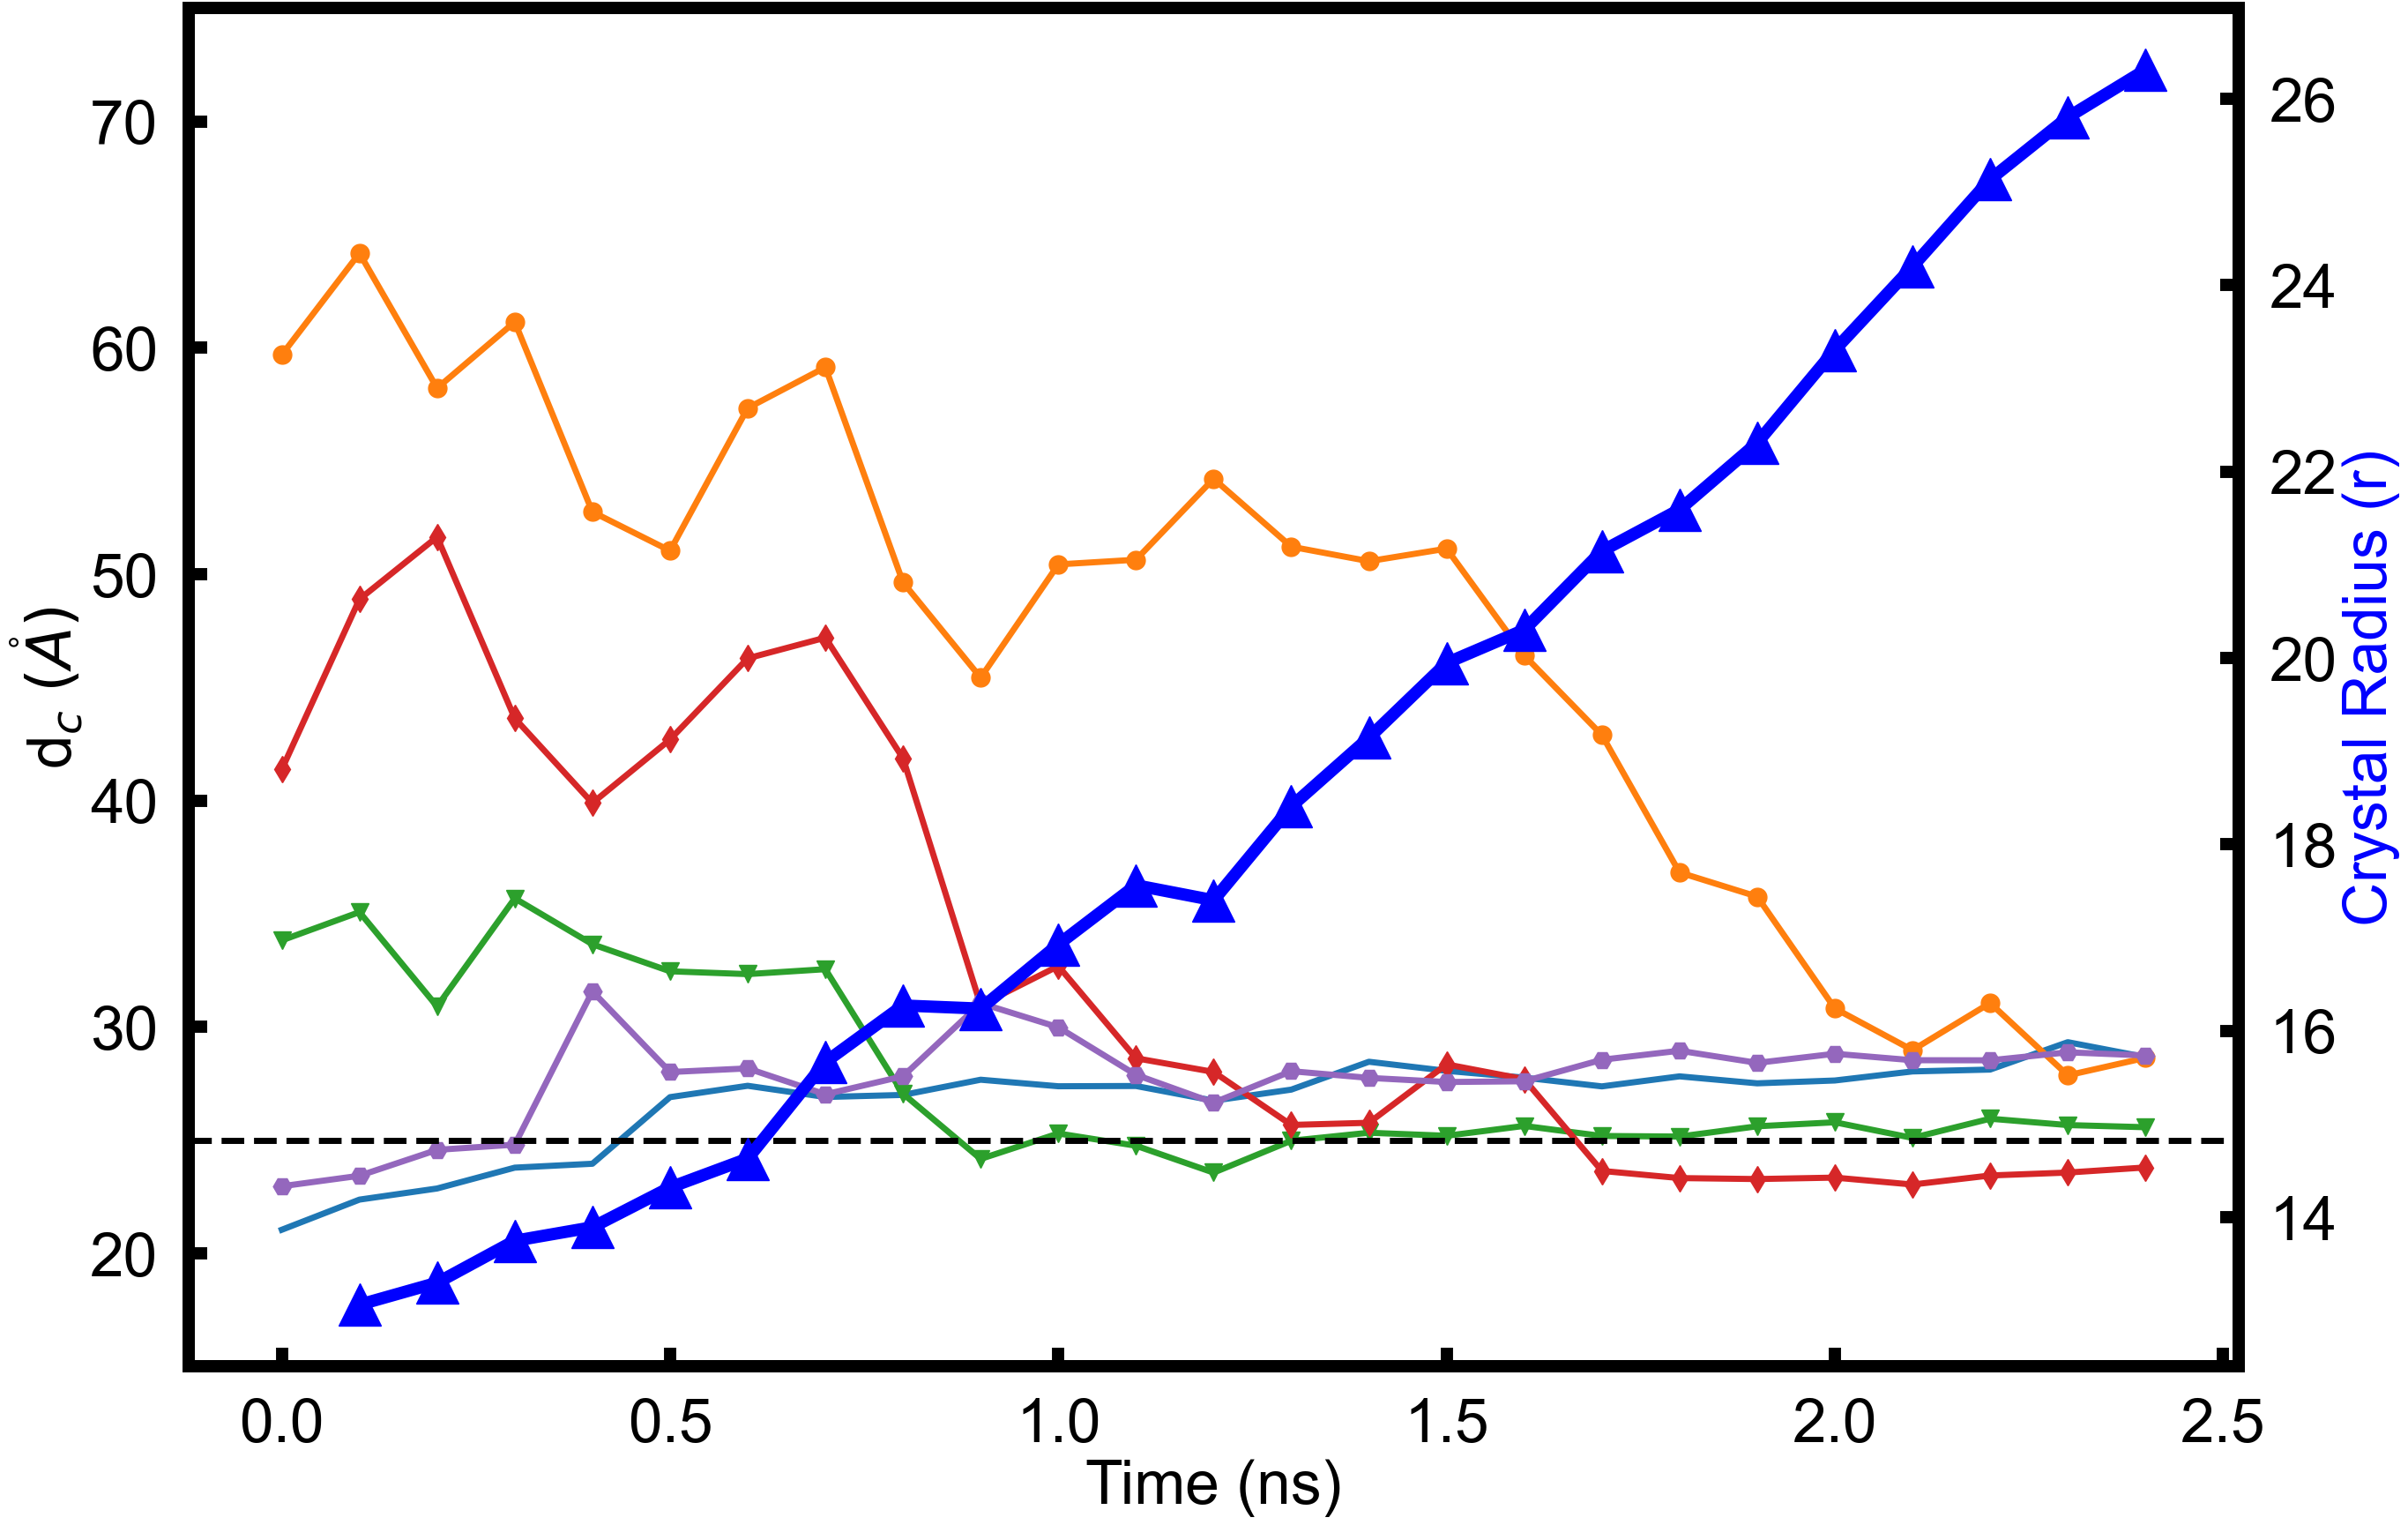

In [113]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 50
plt.rcParams['axes.labelsize'] = 50
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 75
plt.rcParams['axes.titleweight']='normal'
plt.rcParams['xtick.labelsize'] =50
plt.rcParams['ytick.labelsize'] =50
plt.rcParams['lines.linewidth']=5.0
plt.rcParams['figure.figsize'] = 30,20
plt.rcParams['lines.markersize']=15.0
plt.rcParams['axes.linewidth'] =10

plt.rcParams['xtick.major.size']=15
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['xtick.major.width']=10.0

plt.rcParams['ytick.major.size']=15
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['ytick.major.width']=10.0

plt.rcParams['xtick.major.pad']='25'
plt.rcParams['ytick.major.pad']='25'
markers = [',','o','v','d','H','*','X','p','^','<','>','s']

fig, ax1 = plt.subplots()

# Creating another y-axis and plotting the second set of data on the right y-axis
ax2 = ax1.twinx()


t = np.arange(0.0,2.5,0.1)
for ind in range(len(num_list_Si)):
    ax1.plot(t,stored_vals[ind,1:],marker=markers[ind])#,label=str(stored_vals[ind,0]))
ax2.plot(np.arange(0.1,2.5,0.1), eq_sphere, color = 'blue', marker='^', markersize=35.0, lw=10.0)    

ax1.axhline(y=25.0, linestyle='--',color='k')
ax1.set_ylabel("d$_c$ $(\mathring{A})$")
ax2.set_ylabel("Crystal Radius (r)", color='blue')
ax1.set_xlabel("Time (ns)")
ax1.set_ylim(15,75)
plt.savefig("Si_lt_30_2p4ns.pdf",bbox_inches='tight')
plt.show()